# Cardiac LV 17-segment model

This notebook demonstrates how to use the geometric algorithm to automatically segment the 17-segment Left Ventricle myocardium model defined by the AHA: https://www.ahajournals.org/doi/pdf/10.1161/hc0402.102975

In [1]:
try:
    import platipy
except:
    # Install platipy with the 'cardiac' extra since that contains some extra libraries we need.
    !pip install platipy[cardiac]
    import platipy

from pathlib import Path
import matplotlib.pyplot as plt

import SimpleITK as sitk
import numpy as np

from platipy.imaging import ImageVisualiser
from platipy.imaging.label.utils import get_com
from platipy.imaging.utils.io import write_nrrd_structure_set
from platipy.imaging.utils.ventricle import generate_left_ventricle_segments

from platipy.imaging.projects.cardiac.run import install_open_atlas


## Download Sample Data

PlatiPy's cardiac segmentation tool uses an atlas as part of that segmentation. For this example we download that atlas to demonstrate the 17-segment auto-segmentation.

In [2]:
atlas_path = Path("data/atlas")

if not atlas_path.exists():
    install_open_atlas(atlas_path)

## Read Data

We read in some of the data we downloaded. The required structures are: Left Ventricle, Left Atrium, Right Ventricle and the whole heart. The CT image is loaded but is only needed for visualisation purposes.

In [3]:
patid = "LUNG1-002"

image_path = atlas_path.joinpath(patid, "IMAGES", "CT.nii.gz")
image = sitk.ReadImage(str(image_path)) # onyl used for visualisation

contours = {}

lv_path = atlas_path.joinpath(patid, "STRUCTURES", "Ventricle_L.nii.gz")
contours["Ventricle_L"] = sitk.ReadImage(str(lv_path))

la_path = atlas_path.joinpath(patid, "STRUCTURES", "Atrium_L.nii.gz")
contours["Atrium_L"] = sitk.ReadImage(str(la_path))

rv_path = atlas_path.joinpath(patid, "STRUCTURES", "Ventricle_R.nii.gz")
contours["Ventricle_R"] = sitk.ReadImage(str(rv_path))

heart_path = atlas_path.joinpath(patid, "STRUCTURES", "Heart.nii.gz")
contours["Heart"] = sitk.ReadImage(str(heart_path))

## Generate 17 LV Segments

The `generate_left_ventricle_segments` function is run which returns a dictionary where the key is the segment ID (i.e. Ventricle_L_Segment1, Ventricle_L_Segment2, ...) and the value is the segment auto-contour (as a SimpleITK.Image).

See the [documentation](https://pyplati.github.io/platipy/utils.html#module-platipy.imaging.utils.ventricle) for additional options you can specify.

In [4]:
lv_segments = generate_left_ventricle_segments(contours, verbose=True)

Beginning LV segmentation algorithm.
Module 1: Cropping and initial alignment.
  Images cropped. Volume reduction: 1.000
  Alignment computed.
    Cardiac axis:     [-0.51538678 -0.8567381   0.01939842]
    Rotation axis:    [-0.8567381  -0.01939842  0.        ]
    Rotation angle:   1.0293374025288489
    Rotation centre:  (53.54705757769439, -33.01797661455572, -33.16549199516518)
Module 2: LV orientation alignment.
  Optimiser tolerance (degrees) = 1
  Beginning alignment process
    N:                1
    LV apex:          [  92.12689862  -29.34676304 -100.3999939 ]
    MV COM:           [ 38.60792831 -34.98956324 -14.50176381]
    LV axis:          [ 53.51897031   5.6428002  -85.89823009]
    Rotation axis:    [  5.6428002  -53.51897031   0.        ]
    Rotation centre:  [ 65.36741347 -32.16816314 -57.45087885]
    Rotation angle:   0.5596804399185753
    N:                2
    LV apex:          [  74.15895319  -25.37873232 -112.3999939 ]
    MV COM:           [ 65.39114152 -32

## Visualise Segments

Here we generate a figure using the CT loaded to visualise the results.

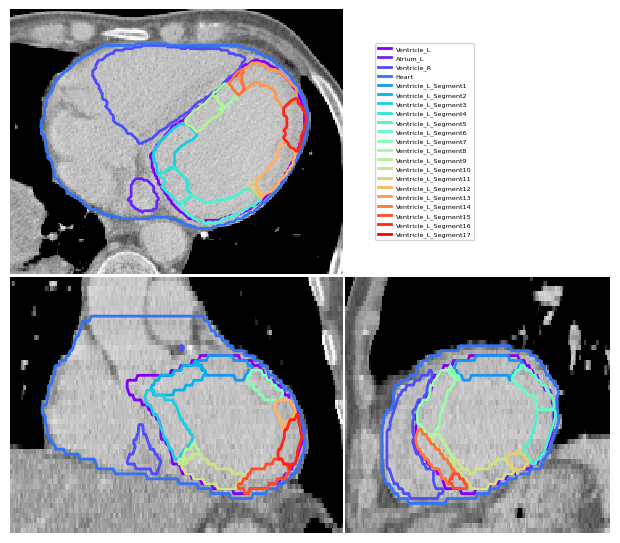

In [5]:
vis = ImageVisualiser(image, cut=get_com(contours["Ventricle_L"]), figure_size_in=6)
vis.add_contour(contours)
vis.add_contour(lv_segments)
vis.set_limits_from_label(contours["Heart"], expansion=20)
fig = vis.show()

Optionally save a NRRD file containing all LV segments. This is useful for loading into Slicer (for example).


In [6]:
write_nrrd_structure_set(lv_segments, atlas_path.joinpath(patid, "STRUCTURES", "LV_Segments.nrrd"), colormap=plt.cm.rainbow)